**In previous notebooks, Hws were estimated from reanalysis (Notebook 1), then a detailed pre-processing and quality control of ARPA and CML were performed (Notebook 2), and finally, average air temperature observations during selected HWs were exported (Notebook 3).**

**This notebook executes the main air temperature prediction. It will iterate over each HW and each diurnal/nocturnal period. For details, please refer to the article: "XXX".**

**Inputs are: CSV files with average air temperature and a set of predictors coming from EO and geospatial datasets. Predictors have been precomputed with [Google Earth Engine](https://earthengine.google.com/) or [QGIS](https://qgis.org/).**

In [1]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio
from shapely.geometry import Point
from rasterstats import point_query
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import math
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display

# Predictor selection. There are 8 predictors. This dropdown allows the selection of some of them or all.
predictors_options = ['LCZ', 'NDVI', 'IMD', 'SWIR1', 'SWIR2', 'SVF', 'DTM', 'CH']
checkboxes = [widgets.Checkbox(value=True, description=option) for option in predictors_options]
checkbox_widget = widgets.VBox(checkboxes)
display(checkbox_widget)

# Normalisation selection
normalization_w = widgets.RadioButtons(
    options=['YES', 'NO'],
    description='Use normalized predictors?',
    style={'description_width': 'initial'}
)
display(normalization_w)

RadioButtons(description='Use normalized predictors?', options=('YES', 'NO'), style=DescriptionStyle(descripti…

In [2]:
# Extract once
selected_predictors = [cb.description for cb in checkboxes if cb.value]
normalization = normalization_w.value

# **Air temperature prediction pipeline**

Here, the main pipeline is defined.

In [3]:
def run_rf_pipeline(month, hour, predictors, normalization):

    print(f"Running pipeline for {month} - {hour}...")

    # Load temperature data
    data = f'./Data/CML-ARPA/HW_extracted/CML-ARPA_HW_{month}_2022_{hour}.csv'
    data_df = pd.read_csv(data)

    geometry = [Point(xy) for xy in zip(data_df['long'], data_df['lat'])]
    data_gdf = gpd.GeoDataFrame(data_df, geometry=geometry, crs='EPSG:4326')
    data_gdf = data_gdf.to_crs(epsg=32632)

    # Merge LCZ and train/test labels
    data_class_df = pd.read_csv('./Data/CML-ARPA/ARPA_CML_metadata.csv', delimiter=',')
    data_class_df = data_class_df[['station', 'dominant_class', 'train/test', 'urban/natural']]
    data_class_df.rename(columns={'dominant_class': 'LCZ'}, inplace=True)

    merged_df = pd.merge(data_gdf, data_class_df, on='station', how='inner')
    data_train = merged_df.loc[merged_df['train/test'] == 'train'].copy()
    data_test = merged_df.loc[merged_df['train/test'] == 'test'].copy()

    # Predictors - focal statistic with a mean in a 150m buffer was applied.
    predictors_dict = {
        'NDVI': f'./Data/AT_Predictors/NDVI_2022_{month}_mean150.tif',
        'LCZ': f'./Data/AT_Predictors/LCZ_{month}_20m_majority150.tif',
        'IMD': './Data/AT_Predictors/IMD_Copernicus_2018_20m_mean150.tif', #static
        'SWIR1': f'./Data/AT_Predictors/SWIR1_2022_{month}_mean150.tif',
        'SWIR2': f'./Data/AT_Predictors/SWIR2_2022_{month}_mean150.tif',
        'SVF': './Data/AT_Predictors/SVF_Final_20m_mean150.tif', #static
        'DTM': './Data/AT_Predictors/Elevation_20m_mean150.tif', #static
        'CH': './Data/AT_Predictors/Canopy_Heights_ETH_20m_mean150.tif' #static
    }

    if normalization == 'YES':
        predictors_dict.update({
            'LCZ': f'../Data/AT_Predictors/LCZ_{month}_20m_norm_majority.tif',
            'IMD': '../Data/AT_Predictors/IMD_Copernicus_2018_20m_norm_mean.tif', #static
            'SWIR1': f'../Data/AT_Predictors/SWIR1_2022_{month}_norm_mean.tif',
            'SWIR2': f'../Data/AT_Predictors/SWIR2_2022_{month}_norm_mean.tif',
            'DTM': '../Data/AT_Predictors/Elevation_20m_norm_mean.tif', #static
        })
    
    predictors_dict = {k: v for k, v in predictors_dict.items() if k in predictors}
    selected_features = list(predictors_dict.keys())

    # Sample predictors
    for pred in predictors_dict:
        raster = predictors_dict[pred]
        data_train[pred] = point_query(data_train.geometry, raster, nodata=-999)
        data_test[pred] = point_query(data_test.geometry, raster, nodata=-999)

    # Drop rows with any NaNs in predictors
    data_train = data_train.dropna(subset=predictors)
    data_test = data_test.dropna(subset=predictors)
    
    # Train/Test split
    X_train = data_train[predictors]
    y_train = data_train['avg_temp']
    X_test = data_test[predictors]
    y_test = data_test['avg_temp']

    # --- Hyperparameter Tuning ---
    param_dist = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, 30, None],
        'max_features': ['sqrt', 0.8, 1.0],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }

    rf = RandomForestRegressor(random_state=42)

    # Randomized search over the grid defined above is defined with mean squared error as the target metric
    search = RandomizedSearchCV(
        rf,
        param_distributions=param_dist,
        n_iter=20,
        scoring='neg_mean_squared_error',
        cv=5,
        n_jobs=-1,
        verbose=0,
        random_state=42
    )
    search.fit(X_train, y_train)
    best_params = search.best_params_

    print(f"Best hyperparameters for {month}-{hour}: {best_params}")

    # Train final model using best hyperparameters
    regr = RandomForestRegressor(**best_params, random_state=42)
    regr.fit(X_train, y_train)

    # --- Prediction and Evaluation ---
    y_pred = regr.predict(X_test)
    mae = round(mean_absolute_error(y_test, y_pred), 3)
    rmse = round(math.sqrt(mean_squared_error(y_test, y_pred)), 3)
    r2_test = round(r2_score(y_test, y_pred), 3)

    y_train_pred = regr.predict(X_train)
    mae_train = round(mean_absolute_error(y_train, y_train_pred), 3)
    rmse_train = round(math.sqrt(mean_squared_error(y_train, y_train_pred)), 3)
    r2_train = round(r2_score(y_train, y_train_pred), 3)

    # Feature importance (from final model)
    feat_imp = dict(zip(selected_features, regr.feature_importances_))

    print(f"Done → TEST → MAE: {mae}, RMSE: {rmse}, R2: {r2_test}")
    print(f"       TRAIN → MAE: {mae_train}, RMSE: {rmse_train}, R2: {r2_train}")

    # Predict full raster
    raster_arrays = []
    for pred in selected_features:
        with rasterio.open(predictors_dict[pred]) as src:
            array = src.read(1).astype(np.float32)
            raster_arrays.append(array)
            if pred == selected_features[0]:
                meta = src.meta.copy()

    stack = np.stack(raster_arrays, axis=0)
    n_bands, height, width = stack.shape
    flat_stack = stack.reshape(n_bands, -1).T

    pred_full = regr.predict(flat_stack)
    pred_raster = pred_full.reshape(height, width)

    #Save prediction raster
    meta.update({'count': 1, 'dtype': 'float32'})
    out_path = f'./Figures_Exports/AT_outputs/pred_rf_{month}_{hour}.tif'
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    with rasterio.open(out_path, 'w', **meta) as dst:
        dst.write(pred_raster.astype(np.float32), 1)

    print(f"Prediction raster saved to {out_path}")

    result = {
        'month': month,
        'hour': hour,
        'MAE_test': mae,
        'RMSE_test': rmse,
        'R2_test': r2_test,
        'MAE_train': mae_train,
        'RMSE_train': rmse_train,
        'R2_train': r2_train,
        **dict(zip(predictors, regr.feature_importances_))
    }

    return result, selected_features, best_params

In [4]:
# Executing the pipeline, which will iterate over each HW and diurnal/nocturnal period

results_all = []
selected_feats_all = []
best_params_all = []

months = ['Feb', 'May', 'June', 'July', 'Oct']
hours = ['HP', 'WP', 'CP1', 'CP2', 'MUHI']

for m in months:
    for h in hours:
        print(f"\n>>> Running for {m} - {h}")
        # Assuming selected_predictors and normalization are defined outside
        result, selected_features, best_params = run_rf_pipeline(m, h, selected_predictors, normalization)
        
        results_all.append(result)
        selected_feats_all.append({
            "month": m,
            "hour": h,
            "selected_features": selected_features
        })
        best_params_all.append({
            "month": m,
            "hour": h,
            **best_params
        })


>>> Running for Feb - HP
Running pipeline for Feb - HP...
Best hyperparameters for Feb-HP: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30}
Done → TEST → MAE: 0.539, RMSE: 0.61, R2: 0.227
       TRAIN → MAE: 0.346, RMSE: 0.446, R2: 0.767


C:\Users\matey\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Prediction raster saved to ./Figures_Exports/AT_outputs/pred_rf_Feb_HP.tif

>>> Running for Feb - WP
Running pipeline for Feb - WP...


SystemError: <cyfunction DatasetReaderBase._read at 0x000002E368358450> returned a result with an exception set

In [9]:
# Exporting: RF results (MAE, RMSE, R2 for train & test and feature importances).
results_df = pd.DataFrame(results_all)
results_df.to_csv('./Figures_Exports/AT_outputs/RF_results.csv', index=False)

# Exporting: selected features in the case of feature selection.
selected_feats_df = pd.DataFrame(selected_feats_all)
selected_feats_df.to_csv('./Figures_Exports/AT_outputs/RF_selected_feats.csv', index=False)

# Exporting: best combination of hyperparameters.
best_params_df = pd.DataFrame(best_params_all)
best_params_df.to_csv('./Figures_Exports/AT_outputs/RF_best_params.csv', index=False)

print("All results saved.")

All results saved.


# **Model evaluation**

Here the model is evaluated on the test set.

In [10]:
# Load the results
df = pd.read_csv('./Figures_Exports/AT_outputs/RF_results.csv')

## **R2**

In [11]:
phase_order = ['HP', 'WP', 'CP1', 'CP2', 'MUHI']
month_order = ['Feb', 'May', 'June', 'July', 'Oct']

df['month'] = pd.Categorical(df['month'], categories=month_order, ordered=True)

heatmap_data = df.pivot(index='month', columns='hour', values='R2_test')
heatmap_data = heatmap_data.loc[month_order, phase_order]

plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    heatmap_data,
    annot=True,
    annot_kws={"fontsize": 13},
    cmap='cividis',
    fmt=".2f",
    cbar_kws={
        'label': None,
        'orientation': 'vertical'
    },
    linewidths=0.5,
    linecolor='white'
)

ax.set_xlabel('Diurnal/nocturnal phase', weight='bold', fontsize=14)
ax.set_ylabel('HW', weight='bold', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=13)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=13, rotation=0)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=13) 
cbar.ax.set_title("R²", fontsize=13, weight='bold', pad=10)

plt.tight_layout()
plt.savefig('./Figures_Exports/R2_heatmap.png', dpi=600)
plt.show()

KeyError: "['May', 'June', 'July', 'Oct'] not in index"

## **Feature importance**

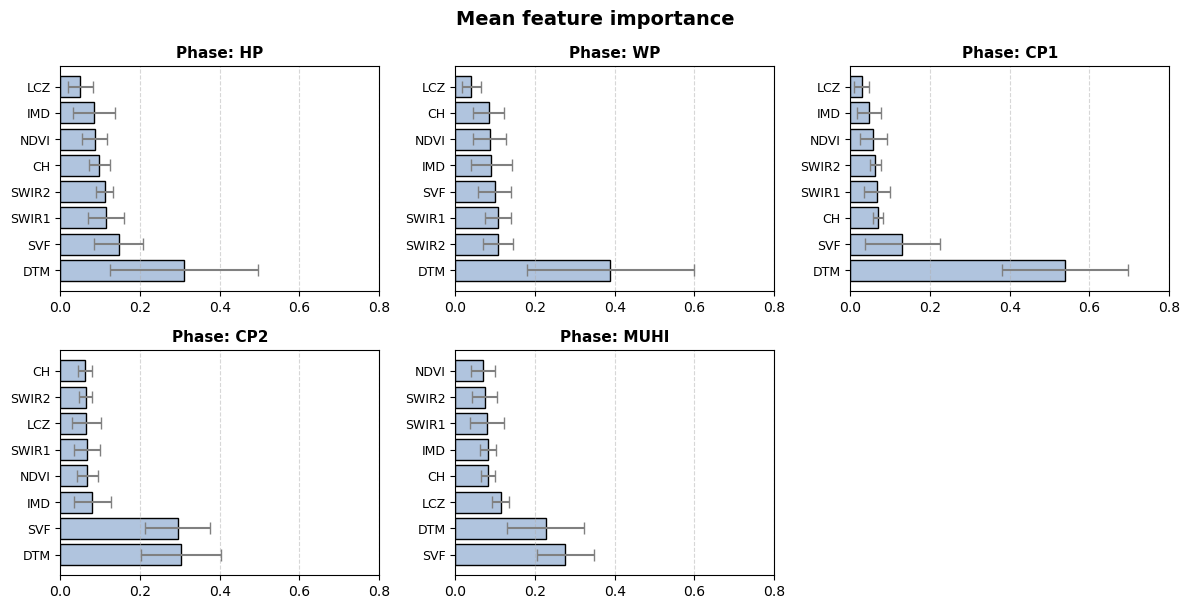

In [7]:
predictors = ['LCZ', 'DTM', 'SWIR1', 'SWIR2', 'CH', 'SVF', 'NDVI', 'IMD']
phases = ['HP', 'WP', 'CP1', 'CP2', 'MUHI']

x_min = 0  
x_max = 0.8  

# Plot setup: 2 rows x 3 columns (last subplot will be empty)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6.5), sharex=False)
axes = axes.flatten()

for i, phase in enumerate(phases):
    sub_df = df[df['hour'] == phase]
    
    mean_vals = sub_df[predictors].mean()
    std_vals = sub_df[predictors].std()
    
    # Sort values for readability
    sorted_idx = mean_vals.sort_values().index
    mean_vals = mean_vals[sorted_idx]
    std_vals = std_vals[sorted_idx]
    
    ax = axes[i]
    y_pos = np.arange(len(predictors))
    
    ax.barh(y_pos, mean_vals, xerr=std_vals, color='lightsteelblue', edgecolor='black',
            ecolor='gray', capsize=4)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(mean_vals.index, fontsize=9)
    ax.invert_yaxis()
    ax.set_title(f'Phase: {phase}', fontsize=11, weight='bold')
    ax.set_xlim(x_min, x_max)
    ax.grid(True, axis='x', linestyle='--', alpha=0.5)

# Remove last empty subplot
fig.delaxes(axes[-1])

fig.suptitle("Mean feature importance", fontsize=14, weight='bold')

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig("./Figures_Exports/Feature_importance.png", dpi=600)
plt.show()

## **RMSE**

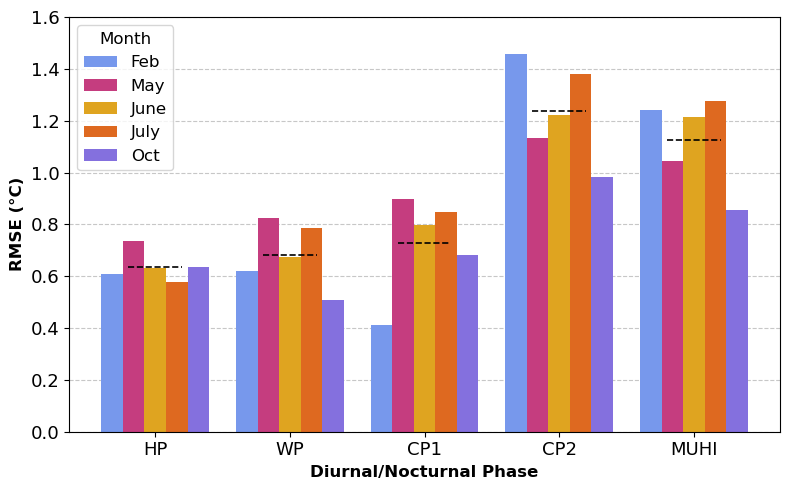

In [8]:
custom_palette = {
    'Feb': '#648FFF',   
    'May': '#DC267F',   
    'June': '#FFB000', 
    'July': '#FE6100',  
    'Oct': '#785EF0'   
}

avg_per_phase = df.groupby('hour')['RMSE_test'].mean()

plt.figure(figsize=(8, 5))
ax = plt.gca()

# Grid behind bars
ax.grid(axis='y', linestyle='--', alpha=0.7, zorder=0)

# Barplot
sns.barplot(
    data=df,
    x='hour',
    y='RMSE_test',
    hue='month',
    palette=custom_palette,
    errorbar='sd',
    ax=ax
)

for patch in ax.patches:
    patch.set_zorder(2)

# Add average lines per phase
x_labels = df['hour'].unique()
x_order = ['HP', 'WP', 'CP1', 'CP2', 'MUHI']  
bar_width = 0.8 / len(df['month'].unique()) 
offset = -0.4 + bar_width * len(df['month'].unique()) / 2

for i, phase in enumerate(x_order):
    avg_val = avg_per_phase[phase]
    ax.hlines(y=avg_val, xmin=i + offset - 0.2, xmax=i + offset + 0.2,
              colors='black', linestyles='dashed', linewidth=1.2, zorder=3)

ax.set_xlabel("Diurnal/Nocturnal Phase", fontsize=12, weight='bold')
ax.set_ylabel("RMSE (°C)", fontsize=12, weight='bold')
ax.set_ylim(0, 1.6)
ax.tick_params(labelsize=13)
ax.legend(title='Month', title_fontsize=12, fontsize=12)

plt.tight_layout()
plt.savefig("./Figures_Exports/rmse_barplot.png", dpi=600)
plt.show()